In [1]:
from hamiltonian import HamiltonianSmall, Hamiltonian

In [2]:
lih = HamiltonianSmall('LiH', 1.5)
beh2 = HamiltonianSmall('BeH2', 1.3)

h2_jw = Hamiltonian('H2_6-31G_8qubits', 'jw')
h2_parity = Hamiltonian('H2_6-31G_8qubits', 'parity')
h2_bk = Hamiltonian('H2_6-31G_8qubits', 'bk')

water_jw = Hamiltonian('H2O_STO3g_14qubits', 'jw')
water_parity = Hamiltonian('H2O_STO3g_14qubits', 'parity')
water_bk = Hamiltonian('H2O_STO3g_14qubits', 'bk')

ammonia_jw = Hamiltonian('NH3_STO3g_16qubits', 'jw')
ammonia_parity = Hamiltonian('NH3_STO3g_16qubits', 'parity')
ammonia_bk = Hamiltonian('NH3_STO3g_16qubits', 'bk')

In [3]:
%time lih.pauli_rep.ground()
%time beh2.pauli_rep.ground()
%time h2_jw.pauli_rep.ground()
%time energy, state = water_jw.pauli_rep.ground()
# %time energy, state = ammonia_jw.pauli_rep.ground() # takes about 4 minutes

CPU times: user 205 ms, sys: 55.6 ms, total: 260 ms
Wall time: 102 ms
CPU times: user 262 ms, sys: 4.9 ms, total: 267 ms
Wall time: 263 ms
CPU times: user 530 ms, sys: 31 ms, total: 560 ms
Wall time: 403 ms
CPU times: user 23 s, sys: 2.72 s, total: 25.7 s
Wall time: 9.88 s


In [4]:
%time lih.pauli_rep.ground(multithread=True)
%time beh2.pauli_rep.ground(multithread=True)
%time h2_jw.pauli_rep.ground(multithread=True)
%time energy, state = water_jw.pauli_rep.ground(multithread=True)
# %time energy, state = ammonia_jw.pauli_rep.ground(multithread=True) # takes about 1 minute

CPU times: user 54.2 ms, sys: 51.3 ms, total: 105 ms
Wall time: 479 ms
CPU times: user 36.6 ms, sys: 42.8 ms, total: 79.4 ms
Wall time: 431 ms
CPU times: user 173 ms, sys: 94.8 ms, total: 268 ms
Wall time: 487 ms
CPU times: user 17 s, sys: 3.16 s, total: 20.2 s
Wall time: 4.12 s


# Variance formula

\begin{align}
    \Var[\nu] 
    &=
    \sum_{\Qarrow,\Rarrow}
        f_\beta(\Qarrow,\Rarrow)
        \alpha_\Qarrow \alpha_\Rarrow
        \tr(\rho\Qarrow\Rarrow)
    - \tr(\rho H_0 )^2
\end{align}

In [5]:
pr = h2_jw.pauli_rep
energy, state = pr.ground()
β = pr.local_dists_uniform()
%time pr.variance_local(energy, state, β)

CPU times: user 1.34 s, sys: 140 ms, total: 1.48 s
Wall time: 681 ms


51.39982021387607

In [6]:
print("ell_1: ", pr.variance_ell_1(energy))

β = pr.local_dists_pnorm(1)
print("1_norm: ", pr.variance_local(energy, state, β))

β = pr.local_dists_pnorm(2)
print("2_norm: ", pr.variance_local(energy, state, β))

β = pr.local_dists_pnorm('infinity')
print("max_norm: ", pr.variance_local(energy, state, β))

ell_1:  119.67906001905907
1_norm:  48.903158500086604
2_norm:  175.39091182541637
max_norm:  849.5697055837951


# Variance optimisation (keyword=diagonal)

This is not the correct optimisation. However it
- gives good results;
- is quicker than the full optimisation problem;
- is convex (so local minimums are global);
- does not need access to the Hartree-Fock bitstring for the encoding.

Diagonal minimisation asks us to find $\{\beta_{i,P}\}$ in order to minimise:
$$
    \sum_{\Qarrow} \alpha_\Qarrow^2 \prod_{i\in\supp(\Qarrow)} \beta_{i,Q_i}^{-1}
    \qquad
    \textrm{subject to}
    \qquad
    \beta_{i,X}+\beta_{i,Y}+\beta_{i,Z}=1 \,\forall i,
    \qquad
    \beta_{i,P}\ge 0
$$

In [7]:
β_optimal_diagonal = pr.local_dists_optimal('diagonal')
print(pr.variance_local(energy, state, β_optimal_diagonal))

17.742071936811424


# Variance optimisation (keyword=mixed)

This is the full optimisation problem. It requires access to the Hartree-Fock bitstring $m$ or `bitstring_HF` so that the HF state reads
$\frac1{2^n}\otimes_{i=1}^n (I+m_i Z)$

In the JW encoding these are:
- H2 = `10001000`
- H2O = `11111001111100`
- NH3 = `1111100011111000`

Consider the set of influential pairs:
\begin{align}
    \mathcal{I}_\mathrm{comp}
    =
    \left\{\left.
        (\Qarrow,\Rarrow)
        \,\right|\,
        \textrm{for all $i$, either $Q_i=R_i$, or $\{Q_i,R_i\}=\{I,Z\}$}
    \right\}
\end{align}

Then the cost function to optimise will be:
\begin{align}
    \mathrm{cost}(\{\beta_i\}_{i=1}^n)
    =
    \sum_{\Qarrow,\Rarrow\in\mathcal{I}_\mathrm{comp}}
        \alpha_\Qarrow
        \alpha_\Rarrow
        \prod_{i | Q_i=R_i\neq I}
            \beta_{i,Q_i}^{-1}
        \prod_{i | Q_i\neq R_i}
            m_i
\end{align}

Warning, the small Hamiltonians don't follow the pattern because they use other reduction techniques

In [8]:
bitstring_HF = '10001000'
β_optimal_mixed = pr.local_dists_optimal('mixed', bitstring_HF)
print(pr.variance_local(energy, state, β_optimal_mixed))

/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


17.457190704104413


# Variance after LDF grouping

We should use 1-norm sampling for $\kappa$

\begin{align}
    \Var[\nu] 
    = 
    \left(
    \sum_{k=1}^{n_c}
        \frac1{\kappa_k} 
        \sum_{\Qarrow,\Rarrow\in C^{(k)}}
            \alpha_\Qarrow\alpha_\Rarrow
            \prod_{i\in\supp(\Qarrow\Rarrow)} \langle \Qarrow\Rarrow \rangle
    \right)
    - \langle H_0 \rangle^2
\end{align}

In [9]:
from var import variance_ldf, kappa_1norm #kappa_uniform

In [10]:
ldf = h2_jw.ldf()
kappa = kappa_1norm(ldf)
energy_tf = pr.energy_tf(energy)
variance_ldf(ldf, state, kappa, energy_tf)

22.259477922991184

# Benchmarking

In [33]:
def variances_dict(ham, β_diag=None, β_mix=None):
    pr = ham.pauli_rep
    dic = {}
    
    energy, state = pr.ground(multithread=True)
    print("energy :", energy)

    # ell_1
    var = pr.variance_ell_1(energy)
    print("ell 1: ", var)
    dic['ell_1'] = var
    
    # LDF with 1-norm sampling
    ldf = ham.ldf()
    kappa = kappa_1norm(ldf)
    energy_tf = pr.energy_tf(energy)
    var = variance_ldf(ldf, state, kappa, energy_tf)
    print("ldf 1norm: ", var)
    dic['ldf_1norm'] = var
    
    # uniform
    β_uniform = pr.local_dists_uniform()
    var = pr.variance_local(energy, state, β_uniform, multithread=True)
    print("uniform: ", var)
    dic['uniform'] = var
    
    # optimal (diagonal)
    if β_diag is not None:
        var = pr.variance_local(energy, state, β_diag, multithread=True)
        print("optimal diagonal: ", var)
        dic['optimal_diag'] = var
 
    # optimal (mixed)
    if β_mix is not None:
        var = pr.variance_local(energy, state, β_mix, multithread=True)
        print("optimal mixed: ", var)
        dic['optimal_mix'] = var
    
    return dic

from matplotlib import pyplot as plt

def variances_graph(variances):
    num_variances = len(variances)
    x = range(num_variances)
    height = list(variances.values())

    plt.bar(x, height)
    plt.xticks(x, list(variances.keys()), rotation=20)
    plt.title(title)

    plt.show()

In [12]:
variances_ALL = {}
beta_optimal_ALL = {}

In [13]:
name = 'h2_jw'
ham = h2_jw
bitstring_HF = '10001000'

title = "Variances for various algorithms on H2 in JW encoding over 8 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

CPU times: user 11 s, sys: 1.19 s, total: 12.2 s
Wall time: 2.47 s
CPU times: user 1min 20s, sys: 7.99 s, total: 1min 28s
Wall time: 26.2 s
=====
Variances for various algorithms on H2 in JW encoding over 8 qubits
=====
energy : -1.860860555520766
ell 1:  119.67906001905905
ldf 1norm:  22.25947792299123
uniform:  51.399820213875984
optimal diagonal:  17.742071936811502
optimal mixed:  17.45719070410452
CPU times: user 619 ms, sys: 289 ms, total: 907 ms
Wall time: 2.14 s


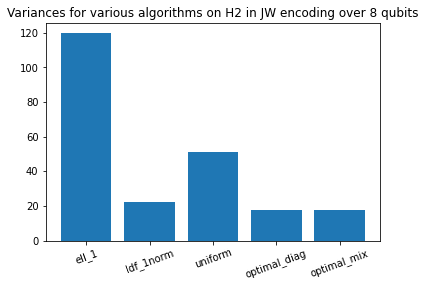

In [35]:
variances_graph(variances_ALL[name])

In [36]:
name = 'water_jw'
ham = water_jw
bitstring_HF = '11111001111100'

title = "Variances for various algorithms on H2O in JW encoding over 14 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


CPU times: user 7min 5s, sys: 1min 5s, total: 8min 10s
Wall time: 1min 12s
CPU times: user 25min 43s, sys: 1min 20s, total: 27min 3s
Wall time: 17min 45s
energy : -83.59943020533822
ell 1:  4363.497773126055
ldf 1norm:  1041.8235013468723
uniform:  2839.039468218958
optimal diagonal:  257.54509937277044
optimal mixed:  254.14108178948072
CPU times: user 21.5 s, sys: 2.39 s, total: 23.8 s
Wall time: 2min 31s
=====
Variances for various algorithms on H2O in JW encoding over 14 qubits
=====


{'ell_1': 4363.497773126055,
 'ldf_1norm': 1041.8235013468723,
 'uniform': 2839.039468218958,
 'optimal_diag': 257.54509937277044,
 'optimal_mix': 254.14108178948072}

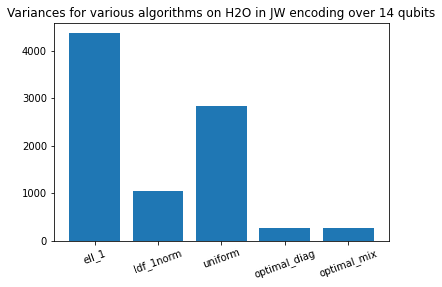

In [37]:
variances_graph(variances_ALL[name])

In [38]:
name = 'ammonia_jw'
ham = water_jw
bitstring_HF = '1111100011111000'

title = "Variances for various algorithms on H2O in JW encoding over 14 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
# rudy needs to help me! this will take too long using my pedestrian approach
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


CPU times: user 6min 47s, sys: 59.7 s, total: 7min 47s
Wall time: 52.4 s
energy : -83.59943020533836
ell 1:  4363.497773126047
ldf 1norm:  1041.8235013468652
uniform:  2839.0394682189535
optimal diagonal:  257.5450993727626
CPU times: user 27.4 s, sys: 3.1 s, total: 30.5 s
Wall time: 1min 46s
=====
Variances for various algorithms on H2O in JW encoding over 14 qubits
=====


{'ell_1': 4363.497773126047,
 'ldf_1norm': 1041.8235013468652,
 'uniform': 2839.0394682189535,
 'optimal_diag': 257.5450993727626}

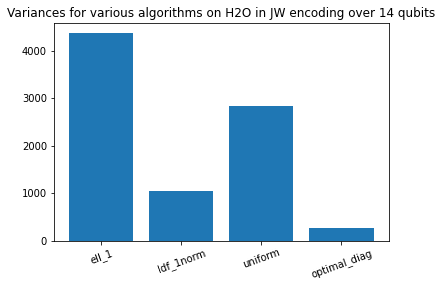

In [39]:
variances_graph(variances_ALL[name])